In [1]:
from skimage.filters import gabor_kernel
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt 
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

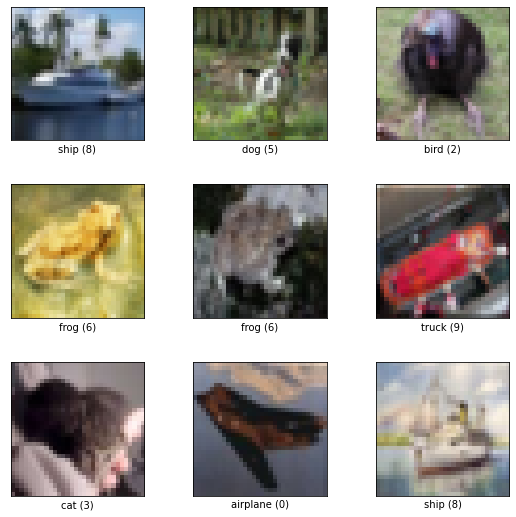

In [2]:
# Construct a tf.data.Dataset
ds, ds_info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, with_info=True, as_supervised=True)

if isinstance(ds, list):
    fig = tfds.show_examples(ds[0], ds_info)
else:
    fig = tfds.show_examples(ds, ds_info)


In [3]:
ds_size = None
train_ds = None
train_size = None
test_ds = None
test_size = None

if isinstance(ds, list):
    train_ds = ds[0]
    train_size = tf.data.experimental.cardinality(train_ds).numpy()
    test_ds = ds[1]
    test_size = tf.data.experimental.cardinality(test_ds).numpy()
    
    ds_size = train_size+test_size
    print("Data size:", ds_size)  
    print("Train size", train_size)
    print("Test size", test_size)
else:
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    print("Data size:", ds_size)

    train_ds = ds.take(0.7 * ds_size)
    train_size = tf.data.experimental.cardinality(train_ds).numpy()
    print("Train size", train_size)

    test_ds = ds.skip(0.7*ds_size)
    test_size = tf.data.experimental.cardinality(test_ds).numpy()
    print("Test size", test_size)


Data size: 60000
Train size 50000
Test size 10000


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 100
IMAGE_SIZE = 32
NUM_OF_CLASSES = 10

In [5]:
import math

def process_dataset(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
#     image = tf.image.per_image_standardization(image)
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize images from 32x32 to 227x227
#     image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))

    image = image/255.0
    
#     label = tf.one_hot(tf.cast(label, tf.int32), NUM_OF_CLASSES)
        
    return image, label

def construct_dataset(ds):
    ds = ds.shuffle(buffer_size=BATCH_SIZE)
#     ds = ds.map(process_dataset,num_parallel_calls=AUTOTUNE)
    
#     ds=ds.repeat()
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_data = construct_dataset(train_ds)
test_data = construct_dataset(test_ds)

steps_per_epoch=math.ceil(train_size/BATCH_SIZE)
validation_steps=math.ceil(test_size/BATCH_SIZE)

In [6]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam

# dimensionality of input and latent encoded representations
inpt_dim = (32, 32, 3)

inpt_img = Input(shape=inpt_dim)

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = inpt_dim )(inpt_img)

# Block 1
cl1 = Conv2D(64, (3, 3), strides=(2, 2),activation='relu')(rescale)
bnl2 = BatchNormalization()(cl1)
# afl3 = Activation('relu')(bnl2)
pl4 = MaxPooling2D(pool_size = (2, 2))(bnl2)

# Adding a second convolutional layer
cl5 = Conv2D(128, (3, 3), strides=(1, 1), activation='relu')(pl4)
bnl6 = BatchNormalization()(cl5)
# afl7 = Activation('relu')(bnl6)
pl8 = MaxPooling2D(pool_size = (2, 2))(bnl6)
bnl9 = BatchNormalization()(pl8)

# Step 3 - Flattening
fl10 = Flatten()(bnl9)

# Step 4 - Full connection
dol11 = Dropout(0.5)(fl10)
dl12 = Dense(units = 256, activation = 'relu')(dol11)
dol13 = Dropout(0.2)(dl12)
dl14 = Dense(units = 64, activation = 'relu')(dol13)
dol15 = Dropout(0.1)(dl14)
output = Dense(units = 10, activation = 'softmax')(dol15)

classifier = Model(inpt_img, output)

# Compiling the CNN
opt = RMSprop(learning_rate=0.001)
# opt = Adam(learning_rate=0.01)

classifier.compile(optimizer = opt, loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   metrics = ['accuracy'])

print(classifier.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 15, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)        

In [ ]:
# Fitting the CNN to the images

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import time

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)

stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)


start = time.perf_counter()
hist = classifier.fit(train_data,  epochs=1000, 
                   callbacks=[stop_alg, reduce_lr], 
                      validation_steps=validation_steps,
                      steps_per_epoch=steps_per_epoch,
                   validation_data=test_data)
finish = time.perf_counter()



Epoch 1/1000
500/500 [==============================] - 53s 106ms/step - loss: 2.0637 - accuracy: 0.3921 - val_loss: 2.1370 - val_accuracy: 0.3153
Epoch 2/1000
500/500 [==============================] - 48s 97ms/step - loss: 2.0054 - accuracy: 0.4505 - val_loss: 2.0428 - val_accuracy: 0.4117
Epoch 3/1000
500/500 [==============================] - 52s 104ms/step - loss: 1.9833 - accuracy: 0.4733 - val_loss: 1.9881 - val_accuracy: 0.4668
Epoch 4/1000
500/500 [==============================] - 56s 111ms/step - loss: 1.9653 - accuracy: 0.4915 - val_loss: 2.0407 - val_accuracy: 0.4148
Epoch 5/1000
500/500 [==============================] - 54s 109ms/step - loss: 1.9562 - accuracy: 0.5013 - val_loss: 2.0203 - val_accuracy: 0.4367
Epoch 6/1000
500/500 [==============================] - 58s 117ms/step - loss: 1.9446 - accuracy: 0.5127 - val_loss: 1.9720 - val_accuracy: 0.4857
Epoch 7/1000
500/500 [==============================] - 62s 124ms/step - loss: 1.9403 - accuracy: 0.5177 - val_loss: 1.

500/500 [==============================] - 62s 125ms/step - loss: 1.8348 - accuracy: 0.6251 - val_loss: 1.9193 - val_accuracy: 0.5397
Epoch 56/1000
500/500 [==============================] - 62s 125ms/step - loss: 1.8326 - accuracy: 0.6269 - val_loss: 1.8352 - val_accuracy: 0.6241
Epoch 57/1000
500/500 [==============================] - 63s 126ms/step - loss: 1.8320 - accuracy: 0.6279 - val_loss: 1.8408 - val_accuracy: 0.6190
Epoch 58/1000
500/500 [==============================] - 61s 122ms/step - loss: 1.8322 - accuracy: 0.6276 - val_loss: 1.8220 - val_accuracy: 0.6375
Epoch 59/1000
500/500 [==============================] - 55s 110ms/step - loss: 1.8298 - accuracy: 0.6304 - val_loss: 1.8604 - val_accuracy: 0.6002
Epoch 60/1000
500/500 [==============================] - 57s 114ms/step - loss: 1.8319 - accuracy: 0.6279 - val_loss: 1.8386 - val_accuracy: 0.6202
Epoch 61/1000
500/500 [==============================] - 57s 114ms/step - loss: 1.8307 - accuracy: 0.6288 - val_loss: 1.8338 -

500/500 [==============================] - 59s 119ms/step - loss: 1.7815 - accuracy: 0.6786 - val_loss: 1.7898 - val_accuracy: 0.6686
Epoch 109/1000
500/500 [==============================] - 59s 118ms/step - loss: 1.7798 - accuracy: 0.6803 - val_loss: 1.7856 - val_accuracy: 0.6748
Epoch 110/1000
500/500 [==============================] - 61s 122ms/step - loss: 1.7790 - accuracy: 0.6813 - val_loss: 1.7889 - val_accuracy: 0.6701
Epoch 111/1000
500/500 [==============================] - 61s 122ms/step - loss: 1.7805 - accuracy: 0.6796 - val_loss: 1.7908 - val_accuracy: 0.6686
Epoch 112/1000
500/500 [==============================] - 62s 124ms/step - loss: 1.7781 - accuracy: 0.6819 - val_loss: 1.7916 - val_accuracy: 0.6677
Epoch 113/1000
500/500 [==============================] - 59s 118ms/step - loss: 1.7809 - accuracy: 0.6789 - val_loss: 1.7842 - val_accuracy: 0.6762
Epoch 114/1000
500/500 [==============================] - 58s 116ms/step - loss: 1.7772 - accuracy: 0.6825 - val_loss: 1.